# Encodings

Nous allons explorer les différents encodings avec un jeu de données synthétiques.

In [ ]:
import pandas as pd
import numpy as np

# Nombre d'exemples
n_samples = 500

# Générer les features numériques
np.random.seed(42)
surface = np.random.randint(30, 250, n_samples)       # surface en m²
rooms = np.random.randint(1, 8, n_samples)           # nombre de pièces
age = np.random.randint(0, 100, n_samples)           # âge de la maison
distance_center = np.round(np.random.uniform(0.5, 30, n_samples), 2)  # km au centre-ville

# Générer les features catégorielles
neighborhood = np.random.choice(['A', 'B', 'C'], n_samples)  # type de quartier
house_type = np.random.choice(['Apartment', 'Detached', 'Semi-detached'], n_samples)
garage = np.random.choice(['Yes', 'No'], n_samples)

# Générer la target (prix) avec un peu de bruit
price = (surface * 3000 + rooms * 10000 - age * 500 +
         (neighborhood == 'A') * 20000 +
         (neighborhood == 'B') * 10000 +
         (house_type == 'Detached') * 30000 +
         (garage == 'Yes') * 15000 +
         np.random.normal(0, 10000, n_samples))

# Créer le DataFrame
df = pd.DataFrame({
    'Surface': surface,
    'Rooms': rooms,
    'Age': age,
    'Distance_to_center': distance_center,
    'Neighborhood': neighborhood,
    'House_type': house_type,
    'Garage': garage,
    'Price': price
})

df.head()


,Surface,Rooms,Age,Distance_to_center,Neighborhood,House_type,Garage,Price
0,132,4,9,25.74,C,Apartment,Yes,445859.296999
1,209,4,55,24.99,B,Detached,No,673597.245166
2,122,4,16,12.22,B,Detached,Yes,467805.680555
3,44,5,73,20.21,B,Semi-detached,Yes,163406.497121
4,136,7,16,6.55,A,Semi-detached,Yes,508438.448231


## 1. Categorical encoding 

Les variables catégorielles sont celles qui ne sont pas des nombres : ce sont des catégories.

Ici nous avons différents cas de figures : les colonnes peuvent avoir deux valeurs ou plus.

In [46]:
{col: df[col].value_counts() for col in df.select_dtypes(include='object').columns}


{'Neighborhood': Neighborhood
 B    179
 A    172
 C    149
 Name: count, dtype: int64,
 'House_type': House_type
 Apartment        177
 Detached         173
 Semi-detached    150
 Name: count, dtype: int64,
 'Garage': Garage
 Yes    251
 No     249
 Name: count, dtype: int64}

### 1.1. `OneHotEncoder`

In [47]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False) # pour l'affichage


In [48]:
df["Neighborhood"]

0      C
1      B
2      B
3      B
4      A
      ..
495    C
496    C
497    A
498    C
499    A
Name: Neighborhood, Length: 500, dtype: object

In [49]:

enc.fit(df["Neighborhood"].values.reshape(-1, 1))
df["Neighborhood"].head()

0    C
1    B
2    B
3    B
4    A
Name: Neighborhood, dtype: object

In [50]:
enc.transform(df["Neighborhood"].head().values.reshape(-1, 1))

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

### 1.2. `OneHotEncoder` deux catégories

In [51]:
enc = OneHotEncoder(sparse_output=False) # pour l'affichage
enc.fit(df["Garage"].values.reshape(-1, 1))

OneHotEncoder(sparse_output=False)

In [52]:
df["Garage"].head()

0    Yes
1     No
2    Yes
3    Yes
4    Yes
Name: Garage, dtype: object

In [53]:
enc.transform(df["Garage"].head().values.reshape(-1, 1))

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

Le problème est que les deux variables sont parfaitement corrélées, ce qui va nuire à des algos sensibles à la colinéarité comme les régressions linéaires. 

Pour résoudre ce problème (connu sous le nom de **dummy variable trap**), on supprime une des deux colonnes

In [54]:
enc = OneHotEncoder(sparse_output=False, drop="first")

enc.fit_transform(df["Garage"].head().values.reshape(-1, 1))


array([[1.],
       [0.],
       [1.],
       [1.],
       [1.]])

### 1.3. `OrdinalEncoder`

Lorsqu'il y a une notion d'ordinalité on utilise cet encoder. Ici c'est le cas pour la colonne `Housetype`

In [55]:
df["House_type"].unique()

array(['Apartment', 'Detached', 'Semi-detached'], dtype=object)

In [56]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories=[['Apartment', 'Semi-detached', 'Detached']])
enc.fit(df["House_type"].values.reshape(-1,1))


OrdinalEncoder(categories=[['Apartment', 'Semi-detached', 'Detached']])

In [15]:
df["House_type"].head()

0        Apartment
1         Detached
2         Detached
3    Semi-detached
4    Semi-detached
Name: House_type, dtype: object

In [57]:
enc.transform(df["House_type"].head().values.reshape(-1,1))

array([[0.],
       [2.],
       [2.],
       [1.],
       [1.]])

## 2. Numerical encoding


Vous connaissez déjà les `StandardScaler`, d'autres preprocessors existent : Power Transformer, RobustScaler etc...

Un preprocessor intéressant est le `KBinsDiscretizer` qui "met les valeurs dans des boîtes" i.e. les discrétise / échantillone. 

C'est aussi l'idée derrière le `QuantileTransformer`.

In [58]:
from sklearn.preprocessing import KBinsDiscretizer

enc = KBinsDiscretizer(n_bins=3)

enc.fit(df["Age"].values.reshape(-1, 1))

KBinsDiscretizer(n_bins=3)

<Axes: ylabel='Frequency'>

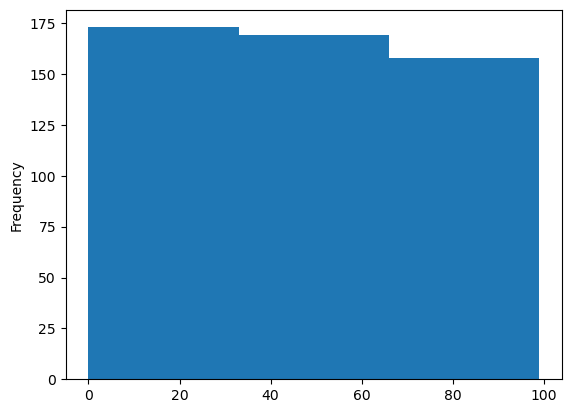

In [59]:
df["Age"].plot(kind="hist", bins=3)

In [35]:
df["Age"].head()

0     9
1    55
2    16
3    73
4    16
Name: Age, dtype: int64

In [60]:
enc.transform(df["Age"].head().values.reshape(-1, 1))

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (5, 3)>

Cette idée permet de régulariser nos données e.g. en créant des catégories :

- faible
- moyen 
- fort

## 3. Combiner les encodings dans une pipeline

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer

X = df.drop('Price', axis=1)
y = df['Price']

# Colonnes numériques et catégorielles
num_features = ['Surface', 'Rooms', 'Age', 'Distance_to_center']
cat_features = ['Neighborhood', 'House_type', 'Garage']

# Définir le transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Surface', 'Rooms', 'Age',
                                  'Distance_to_center']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Neighborhood', 'House_type', 'Garage'])])

In [62]:
preprocessor.fit(X)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Surface', 'Rooms', 'Age',
                                  'Distance_to_center']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Neighborhood', 'House_type', 'Garage'])])

# Exercice : pipeline complète sur ce dataset

- séparer en train et test

- encoding :
  - ordinal sur House type
  - one hot sur les autres
  - Standard Scaler sur les variables numériqeus

- faire une baseline avec un DummyRegressor

- GridSeacher avec un lasso sur l'ensemble de train 

- réentrainer le meilleur modèle sur tout le train 

- regarder la rmse sur l'ensemble de test